#** [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)**
* 개와 고양이 이미지에 대해 학습한 뒤, 입력 이미지가 개일 확률을 구하는 문제
* Data 설명
  - Color depth: RGB color image (jpg)
  - image size: 다양
  - 이미지 유형
    + 얼굴만 존재 / 몸통 일부도 포함 / 몸통 전체 포함
    + 정면뿐만이 아니라, 다양한 방향과 각도에서 촬영된 이미지 존재
    + 이미지에 꽉차게 존재 vs. 일부 영역에 존재
    + occlusion 존재하는 경우도 있음
    + focus out 이미지 존재
    + 그래픽이 가미된 편집 이미지 존재
  - 개수
    + train: 25,000 장
    + test: 12,500 장

* Submission Score
  - 1st (20180523): 0.34785
    + Basic CNN: cv 4 layer + fc 2 layer
    + learning data coverage: 1.0
    + learning rate: 0.001
    + epoch: 100
    + batch size: 100

* Reference
  - Kaggle kernel
    + [CatdogNet - Keras Convnet Starter](https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter)
    + [Full Classification Example with ConvNet](https://www.kaggle.com/sentdex/full-classification-example-with-convnet/code)

###**경험 사항**
* Unzip
  - Linux unzip 명령은 속도가 너무 느림 -> python의 zipfile 모듈을 사용하면 window os에서 압축 푸는 속도와 비슷함
* tqdm
  - Progress bar 형태의 진행상황 시각화에 간편하게 사용할 수 있다.
  - Nested loop에서 각 loop의 진행상황을 각각의 progress bar로 표현하고 싶은데, outer loop의 진행상황 갱신이 항상 new line으로 보여짐
    + 공홈에 tqdm_notebook을 사용한 nested loop 적용 예제가 있음
    + tqdm_notebook에서 ipywidgets을 사용하는데, colab에서는 보안의 이유로 ipywidgets을 지원하고 있지 않음
* Colab
  - [메모리] 64 x 64 x 3 이미지 25,000 장 메모리 로드가 가능했다.


##**Todo List**
* ~~Prediction & csv save~~
* ~~validation set 적용~~
* ~~training, validation에 대해서 cost plot 해보기~~
* ~~predicted logit이 이상하게 나오는 듯...파악해보자~~
* ~~test image filename sorting~~
* ~~Prediction 결과 화면 뷰잉~~
* ~~cost 함수 적절하게 사용하고 있는지 check~~
* dataset 적용
* VGG 기본 개요 파악, tensorflow 구현 예제 리뷰, tf.slim 적용해보기
* Traing 이미지 추가
  - 회전
  - horizontal flip
  - vertical flip
* 이미지 일부 영역에 개/고양이 있는 경우를 대비해 인식률을 높이는 방안은??


##**Question**
* Image augmentation 등으로 train data(내용, 양)이 변경된 경우 hyper-parameter 값 변경이 필요한가? (for 성능 또는 학습 관점에서..)
* Overfitting 시작점 이후로도 epoch 진행될 때마다 valication data의 accuracy도 같이 증가하는데, 어떻게 개선 시키면 좋은지.
  - Overfitting 시작 (e, ta, va): 10, 0.65, 0.65
  - trainning 종료 (e, ta, va): 100, 0.95, 0.85
  

##**Colab: Google Drive File Access**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
import zipfile
import os, os.path

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1dleRLnwKzvPmyGF4Dq2P05qT2cZY9Xw2'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.zip')
downloaded = drive.CreateFile({'id':'1rWdtrmlANzYnGTaWSP_fAmOXDg0BEmFx'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test.zip')

In [4]:
!ls -l

total 834384
drwxr-xr-x 1 root root      4096 May 24 00:38 datalab
-rw-r--r-- 1 root root 284478493 May 24 00:38 test.zip
-rw-r--r-- 1 root root 569918665 May 24 00:38 train.zip


In [0]:
def ExtractZip(zipPath, dataPath, dataType, dataNum):
  
    # 해당 폴더가 존재하는지 확인
    doExtract = True
    targetPath = dataPath + "/" + dataType
    if os.path.isdir(targetPath):
        numFile = len(os.listdir(targetPath))
        if numFile == dataNum:
            doExtract = False
    
    if doExtract == True:
        objZip = zipfile.ZipFile(zipPath)
        objZip.extractall(dataPath)
        print("[%s] is extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))
    else:
        print("[%s] is already extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))

In [0]:
DataPath = './data'

In [7]:
ExtractZip('./train.zip', DataPath, "train", 25000)

[./train.zip] is extracted to [./data/train](25000).


In [8]:
ExtractZip('./test.zip', DataPath, "test", 12500)

[./test.zip] is extracted to [./data/test](12500).


In [0]:
from IPython.display import Image

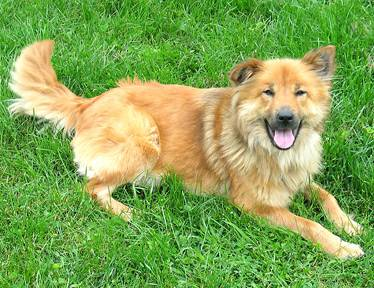

In [10]:
Image('/content/data/test/4.jpg')

##**Train/Test data preparation**

In [11]:
!pip install -U tqdm
!pip install -U ipywidgets

import os, cv2, random
import numpy as np
from tqdm import tqdm
from tqdm import trange, tnrange, tqdm_notebook
from ipywidgets import IntProgress
from time import sleep
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 112kB 2.6MB/s 
Requirement not upgraded as not directly required: ipykernel>=4.5.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.6.1)
Requirement not upgraded as not directly required: ipython>=4.0.0; python_version >= "3.3" in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (5.5.0)
Requirement not upgraded as not directly required: traitlets>=4.3.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.3.2)
Requirement not upgraded as not directly required: nbformat>=4.2.0 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.4.0)
    100% |████████████████████████████████| 2.2MB 7.7MB/s 
Requirement not upgraded as not directly required: jupyter-client in /usr/local/lib/python3.6/dist-packages (from ipykernel>=4.5.1->ipywidgets) (5.2.3)
Requirement not upgraded as not directly required: tornado>=4.0 in /usr/local/lib/python3.6/dist-packages 

In [0]:
#@title Train/Test Image Properties { form-width: "20%" }
ROWS = 64 #@param {type:"integer"}
COLS = 64 #@param {type:"integer"}
CHANNELS = 3 #@param {type:"integer"}


TRAIN_DIR = '/content/data/train/'
TEST_DIR = '/content/data/test/'



def read_image(file_path):
  
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
  
    count = len(images)
    #data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(tqdm(images)):
        image = read_image(image_file)
        # data[i] = image.T
        data[i] = image
    
    return data

  
def labeling(images):
  
  labels = np.ndarray((len(images), 1), dtype=np.uint8)

  for i, image_file in enumerate(images):
      if 'dog' in image_file:
          labels[i] = 1
      else:
          labels[i] = 0
  return labels

In [13]:
#@title Train Data Usage Ratio { form-width: "20%" }
TrainDataCoverage = 1.0     #@param {type:"number"}
TrainDataRatio = 0.7 #@param {type:"number"} # except validation


print("[Load image filename list]")
sleep(0.5)

train_images = [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR))] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'cat' in i]

random.shuffle(train_dogs)
random.shuffle(train_cats)


# data reduction for model build-up efficiency
noTrainDogs = int(len(train_dogs) * TrainDataCoverage)
noTrainCats = int(len(train_cats) * TrainDataCoverage)

train_dogs =  train_dogs[:noTrainDogs]
train_cats =  train_cats[:noTrainCats]


# split train data into real train data and validation data
noTrainDogs = int(len(train_dogs) * TrainDataRatio)
noTrainCats = int(len(train_cats) * TrainDataRatio)

train_images = train_dogs[:noTrainDogs] + train_cats[:noTrainCats]
random.shuffle(train_images)

valid_images = train_dogs[noTrainDogs:] + train_cats[noTrainCats:]
random.shuffle(valid_images)

print("")
print("- Train image count: ", len(train_images))
print("- Validation image count: ", len(valid_images))


print("")
print("[Image loading..]")
train = prep_data(train_images)
valid = prep_data(valid_images)

print("")
print("Train shape: {}".format(train.shape))
print("Valid shape: {}".format(valid.shape))

print("")
print("[Label loading..]")
train_labels = labeling(train_images)
valid_labels = labeling(valid_images)

print("Train image label shape: {}".format(train_labels.shape))
print("Validation image label shape: {}".format(valid_labels.shape))

[Load image filename list]


  0%|          | 51/17500 [00:00<00:34, 503.60it/s]


- Train image count:  17500
- Validation image count:  7500

[Image loading..]


100%|██████████| 7500/7500 [00:13<00:00, 550.76it/s]


Train shape: (17500, 64, 64, 3)
Valid shape: (7500, 64, 64, 3)

[Label loading..]
Train image label shape: (17500, 1)
Validation image label shape: (7500, 1)


##**Build Model: CNN**
* Reference
  - [hunkim: DeepLearningZeroToAll] [lab-11-4-mnist_cnn_layers.py](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-11-4-mnist_cnn_layers.py)

In [0]:
import tensorflow as tf
# import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility

class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
      
        with tf.variable_scope(self.name):
        
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, ROWS, COLS, CHANNELS])

            # img 28x28x1 (black/white), Input Layer
            # X_img = tf.reshape(self.X, [-1, ROWS, COLS, CHANNELS])
            self.Y = tf.placeholder(tf.int32, [None, 1])
            
            Y_one_hot = tf.one_hot(self.Y, 2)
            Y_one_hot = tf.reshape(Y_one_hot, [-1, 2])

            # Convolutional and Polling Layer #1
            conv1 = tf.layers.conv2d(inputs=self.X, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=self.training)
            
            # Convolutional and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)

            # Convolutional and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=self.training)

            # Convolutional and Pooling Layer #4
            conv4 = tf.layers.conv2d(inputs=dropout3, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
            pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], padding="same", strides=2)
            dropout4 = tf.layers.dropout(inputs=pool4, rate=0.3, training=self.training)
            
            # Dense Layer with Relu
            flat = tf.reshape(dropout4, [-1, 256 * 4 * 4])
            dense5 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
            dropout5 = tf.layers.dropout(inputs=dense5, rate=0.5, training=self.training)
            
            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout5, units=2)
            
            self.hypothesis = tf.nn.softmax(self.logits)
            self.prediction = tf.argmax(self.hypothesis, 1)

            print("hypothesis: ", self.hypothesis)
            print("prediction: ", self.prediction)
            
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=Y_one_hot))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(tf.argmax(self.hypothesis, 1), tf.argmax(Y_one_hot, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
      return self.sess.run([self.hypothesis, self.prediction], feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
      return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
      return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})


##**Train**

In [15]:
#@title Hyper-parameter Settings for Training { form-width: "20%" }
learning_rate = 0.001 #@param {type:"number"}
training_epochs = 100 #@param {type:"integer"}
batch_size = 100 #@param {type:"integer"}


tf.reset_default_graph();
        
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print("")
print("Train data count: ", len(train), len(train_labels))
print("Validation data count: ", len(valid), len(valid_labels))

print('Learning Started!')

cost, accuracy_t, accuracy_v = [], [], []

# train my model
for epoch in range(training_epochs):
    
    total_batch = int(len(train) / batch_size)
    avg_cost = 0
    accuracy_train = 0

    for i in trange(total_batch, desc='Batch loop'):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs  = train       [start_idx:end_idx,:,:,:]
        batch_ys  = train_labels[start_idx:end_idx,:]
        
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch
        
        at = m1.get_accuracy(batch_xs, batch_ys)
        accuracy_train += at / total_batch

        
    noValidationLoop = int(len(valid) / batch_size)
    accuracy_valid = 0

    for i in trange(noValidationLoop, desc='Validation accuracy loop'):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs  = valid       [start_idx:end_idx,:,:,:]
        batch_ys  = valid_labels[start_idx:end_idx,:]
        
        av = m1.get_accuracy(batch_xs, batch_ys)
        accuracy_valid += av / noValidationLoop
        

    print('\nEpoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy_train=', '{:.9f}'.format(accuracy_train), 'accuracy_valid=', '{:.9f}'.format(accuracy_valid))
    
    cost.append(c)
    accuracy_t.append(accuracy_train)
    accuracy_v.append(accuracy_valid)
    

print('Learning Finished!')

hypothesis:  Tensor("m1/Softmax:0", shape=(?, 2), dtype=float32)
prediction:  Tensor("m1/ArgMax:0", shape=(?,), dtype=int64)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Batch loop:   0%|          | 0/175 [00:00<?, ?it/s]


Train data count:  17500 17500
Validation data count:  7500 7500
Learning Started!


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.21it/s]


Epoch: 0001 cost = 7.058529756 accuracy_train= 0.515771426 accuracy_valid= 0.517733332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.88it/s]


Epoch: 0002 cost = 0.690556732 accuracy_train= 0.536628571 accuracy_valid= 0.555199994


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.14it/s]


Epoch: 0003 cost = 0.673781619 accuracy_train= 0.565999997 accuracy_valid= 0.601733332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.57it/s]


Epoch: 0004 cost = 0.660808108 accuracy_train= 0.561428570 accuracy_valid= 0.558399998


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.67it/s]


Epoch: 0005 cost = 0.649568315 accuracy_train= 0.596914286 accuracy_valid= 0.611199996


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.64it/s]


Epoch: 0006 cost = 0.638673615 accuracy_train= 0.608971427 accuracy_valid= 0.593866665


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.99it/s]


Epoch: 0007 cost = 0.642132121 accuracy_train= 0.601942855 accuracy_valid= 0.573866666


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.01it/s]


Epoch: 0008 cost = 0.633267848 accuracy_train= 0.641885714 accuracy_valid= 0.666666667


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.70it/s]


Epoch: 0009 cost = 0.609688284 accuracy_train= 0.657485717 accuracy_valid= 0.671466668


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.13it/s]


Epoch: 0010 cost = 0.601600589 accuracy_train= 0.658171430 accuracy_valid= 0.680400001


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.89it/s]


Epoch: 0011 cost = 0.593081422 accuracy_train= 0.690342859 accuracy_valid= 0.697866667


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.50it/s]


Epoch: 0012 cost = 0.578520474 accuracy_train= 0.695200000 accuracy_valid= 0.700133337


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.10it/s]


Epoch: 0013 cost = 0.580940285 accuracy_train= 0.696342856 accuracy_valid= 0.711733332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.93it/s]


Epoch: 0014 cost = 0.579039366 accuracy_train= 0.709428572 accuracy_valid= 0.711066670


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.96it/s]


Epoch: 0015 cost = 0.563404259 accuracy_train= 0.718400001 accuracy_valid= 0.707066670


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.07it/s]


Epoch: 0016 cost = 0.558232095 accuracy_train= 0.726742857 accuracy_valid= 0.708266670


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.64it/s]


Epoch: 0017 cost = 0.550411715 accuracy_train= 0.734799999 accuracy_valid= 0.739199998


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.17it/s]


Epoch: 0018 cost = 0.539235361 accuracy_train= 0.748457144 accuracy_valid= 0.737066666


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.81it/s]


Epoch: 0019 cost = 0.540882861 accuracy_train= 0.754342856 accuracy_valid= 0.737066669


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.10it/s]


Epoch: 0020 cost = 0.528535764 accuracy_train= 0.761885712 accuracy_valid= 0.751466668


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.88it/s]


Epoch: 0021 cost = 0.517963521 accuracy_train= 0.770685714 accuracy_valid= 0.768933334


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.78it/s]


Epoch: 0022 cost = 0.512909835 accuracy_train= 0.775314282 accuracy_valid= 0.769199995


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.84it/s]


Epoch: 0023 cost = 0.498905274 accuracy_train= 0.784457140 accuracy_valid= 0.778000000


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.83it/s]


Epoch: 0024 cost = 0.491537691 accuracy_train= 0.789028572 accuracy_valid= 0.784799995


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.97it/s]


Epoch: 0025 cost = 0.484223103 accuracy_train= 0.803028568 accuracy_valid= 0.776266664


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.65it/s]


Epoch: 0026 cost = 0.477397541 accuracy_train= 0.807428571 accuracy_valid= 0.806933331


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.09it/s]


Epoch: 0027 cost = 0.461632042 accuracy_train= 0.818000000 accuracy_valid= 0.801733335


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.16it/s]


Epoch: 0028 cost = 0.450789132 accuracy_train= 0.826685713 accuracy_valid= 0.791599997


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.97it/s]


Epoch: 0029 cost = 0.444103869 accuracy_train= 0.831371426 accuracy_valid= 0.812533332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.91it/s]


Epoch: 0030 cost = 0.437147839 accuracy_train= 0.840342858 accuracy_valid= 0.818400001


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.81it/s]


Epoch: 0031 cost = 0.427355019 accuracy_train= 0.844628571 accuracy_valid= 0.816133330


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.13it/s]


Epoch: 0032 cost = 0.424857454 accuracy_train= 0.850685711 accuracy_valid= 0.820533329


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.63it/s]


Epoch: 0033 cost = 0.415543475 accuracy_train= 0.854857144 accuracy_valid= 0.821866666


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.88it/s]


Epoch: 0034 cost = 0.409912501 accuracy_train= 0.858857143 accuracy_valid= 0.836266665


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.00it/s]


Epoch: 0035 cost = 0.406414312 accuracy_train= 0.863314284 accuracy_valid= 0.829733330


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.86it/s]


Epoch: 0036 cost = 0.393266099 accuracy_train= 0.869828570 accuracy_valid= 0.829066666


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.83it/s]


Epoch: 0037 cost = 0.391192671 accuracy_train= 0.872514286 accuracy_valid= 0.826533330


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.10it/s]


Epoch: 0038 cost = 0.385770058 accuracy_train= 0.876857141 accuracy_valid= 0.844799999


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.00it/s]


Epoch: 0039 cost = 0.382778346 accuracy_train= 0.879314288 accuracy_valid= 0.842266667


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.96it/s]


Epoch: 0040 cost = 0.378315541 accuracy_train= 0.884057142 accuracy_valid= 0.850133332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.79it/s]


Epoch: 0041 cost = 0.368755128 accuracy_train= 0.884742855 accuracy_valid= 0.842933333


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.05it/s]


Epoch: 0042 cost = 0.373898706 accuracy_train= 0.888285716 accuracy_valid= 0.851733330


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.99it/s]


Epoch: 0043 cost = 0.361958299 accuracy_train= 0.891028571 accuracy_valid= 0.853733335


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.82it/s]


Epoch: 0044 cost = 0.363861002 accuracy_train= 0.893028573 accuracy_valid= 0.855199997


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.34it/s]


Epoch: 0045 cost = 0.352166480 accuracy_train= 0.895485717 accuracy_valid= 0.863466666


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.88it/s]


Epoch: 0046 cost = 0.349618260 accuracy_train= 0.899371429 accuracy_valid= 0.857733335


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.78it/s]


Epoch: 0047 cost = 0.351672621 accuracy_train= 0.898228571 accuracy_valid= 0.859600000


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.02it/s]


Epoch: 0048 cost = 0.342836004 accuracy_train= 0.904857144 accuracy_valid= 0.865599999


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.97it/s]


Epoch: 0049 cost = 0.347480298 accuracy_train= 0.902228572 accuracy_valid= 0.854533331


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.74it/s]


Epoch: 0050 cost = 0.335249931 accuracy_train= 0.904057144 accuracy_valid= 0.862266669


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.95it/s]


Epoch: 0051 cost = 0.341766278 accuracy_train= 0.905028575 accuracy_valid= 0.855866670


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.51it/s]


Epoch: 0052 cost = 0.332674761 accuracy_train= 0.909085715 accuracy_valid= 0.865066668


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.76it/s]


Epoch: 0053 cost = 0.337729247 accuracy_train= 0.907771428 accuracy_valid= 0.864800000


Batch loop:   1%|          | 2/175 [00:00<00:10, 17.26it/s]


Epoch: 0054 cost = 0.338315297 accuracy_train= 0.912114285 accuracy_valid= 0.868799999


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.86it/s]


Epoch: 0055 cost = 0.321409876 accuracy_train= 0.912800001 accuracy_valid= 0.874666669


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.26it/s]


Epoch: 0056 cost = 0.331683094 accuracy_train= 0.916571430 accuracy_valid= 0.860133332


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.51it/s]


Epoch: 0057 cost = 0.319348778 accuracy_train= 0.918971429 accuracy_valid= 0.862666665


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.59it/s]


Epoch: 0058 cost = 0.317700118 accuracy_train= 0.918171431 accuracy_valid= 0.879200002


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.10it/s]


Epoch: 0059 cost = 0.318910371 accuracy_train= 0.922571430 accuracy_valid= 0.863599999


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.84it/s]


Epoch: 0060 cost = 0.322034760 accuracy_train= 0.920342861 accuracy_valid= 0.868799999


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.00it/s]


Epoch: 0061 cost = 0.313315548 accuracy_train= 0.923600002 accuracy_valid= 0.873466668


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.56it/s]


Epoch: 0062 cost = 0.320589429 accuracy_train= 0.920000003 accuracy_valid= 0.876533331


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.96it/s]


Epoch: 0063 cost = 0.311609681 accuracy_train= 0.925714287 accuracy_valid= 0.871333332


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.21it/s]


Epoch: 0064 cost = 0.310621178 accuracy_train= 0.928171433 accuracy_valid= 0.871199996


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.91it/s]


Epoch: 0065 cost = 0.310837326 accuracy_train= 0.924685717 accuracy_valid= 0.878400000


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.85it/s]


Epoch: 0066 cost = 0.301108997 accuracy_train= 0.932800003 accuracy_valid= 0.873066667


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.94it/s]


Epoch: 0067 cost = 0.305948831 accuracy_train= 0.930000003 accuracy_valid= 0.880666667


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.29it/s]


Epoch: 0068 cost = 0.309807387 accuracy_train= 0.926114290 accuracy_valid= 0.872800002


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.94it/s]


Epoch: 0069 cost = 0.298364338 accuracy_train= 0.932685716 accuracy_valid= 0.882533333


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.94it/s]


Epoch: 0070 cost = 0.292153881 accuracy_train= 0.936571430 accuracy_valid= 0.874933334


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.99it/s]


Epoch: 0071 cost = 0.308126808 accuracy_train= 0.932171430 accuracy_valid= 0.883599999


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.99it/s]


Epoch: 0072 cost = 0.297081009 accuracy_train= 0.940742859 accuracy_valid= 0.878933333


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.98it/s]


Epoch: 0073 cost = 0.292575106 accuracy_train= 0.938114286 accuracy_valid= 0.885200001


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.15it/s]


Epoch: 0074 cost = 0.309843289 accuracy_train= 0.934971431 accuracy_valid= 0.869866668


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.07it/s]


Epoch: 0075 cost = 0.303506845 accuracy_train= 0.931485717 accuracy_valid= 0.884666666


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.19it/s]


Epoch: 0076 cost = 0.297050394 accuracy_train= 0.933485716 accuracy_valid= 0.865600000


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.09it/s]


Epoch: 0077 cost = 0.298257006 accuracy_train= 0.940228575 accuracy_valid= 0.884266666


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.80it/s]


Epoch: 0078 cost = 0.298322356 accuracy_train= 0.936514287 accuracy_valid= 0.880800003


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.84it/s]


Epoch: 0079 cost = 0.281071397 accuracy_train= 0.942628573 accuracy_valid= 0.886399999


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.01it/s]


Epoch: 0080 cost = 0.288089392 accuracy_train= 0.941828571 accuracy_valid= 0.878266669


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.89it/s]


Epoch: 0081 cost = 0.283475145 accuracy_train= 0.943314288 accuracy_valid= 0.881333333


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.89it/s]


Epoch: 0082 cost = 0.289863333 accuracy_train= 0.941885719 accuracy_valid= 0.879866664


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.49it/s]


Epoch: 0083 cost = 0.289350852 accuracy_train= 0.940400001 accuracy_valid= 0.875466665


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.13it/s]


Epoch: 0084 cost = 0.280828927 accuracy_train= 0.944800004 accuracy_valid= 0.885866667


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.69it/s]


Epoch: 0085 cost = 0.293452858 accuracy_train= 0.939428574 accuracy_valid= 0.885333331


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.85it/s]


Epoch: 0086 cost = 0.277664090 accuracy_train= 0.942742860 accuracy_valid= 0.886266667


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.14it/s]


Epoch: 0087 cost = 0.282171599 accuracy_train= 0.946400001 accuracy_valid= 0.882533332


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.26it/s]


Epoch: 0088 cost = 0.275817331 accuracy_train= 0.946571427 accuracy_valid= 0.879066666


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.27it/s]


Epoch: 0089 cost = 0.274568680 accuracy_train= 0.948685717 accuracy_valid= 0.885733333


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.46it/s]


Epoch: 0090 cost = 0.267941914 accuracy_train= 0.948857144 accuracy_valid= 0.880933331


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.14it/s]


Epoch: 0091 cost = 0.278077759 accuracy_train= 0.948228576 accuracy_valid= 0.888266670


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.07it/s]


Epoch: 0092 cost = 0.277355929 accuracy_train= 0.947485716 accuracy_valid= 0.872933333


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.04it/s]


Epoch: 0093 cost = 0.279943368 accuracy_train= 0.948228574 accuracy_valid= 0.879333335


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.18it/s]


Epoch: 0094 cost = 0.291083751 accuracy_train= 0.943314289 accuracy_valid= 0.884533335


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.98it/s]


Epoch: 0095 cost = 0.275529836 accuracy_train= 0.946228575 accuracy_valid= 0.882933334


Batch loop:   1%|          | 2/175 [00:00<00:09, 17.73it/s]


Epoch: 0096 cost = 0.276339033 accuracy_train= 0.949885717 accuracy_valid= 0.877466671


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.01it/s]


Epoch: 0097 cost = 0.268848832 accuracy_train= 0.955314287 accuracy_valid= 0.886666669


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.12it/s]


Epoch: 0098 cost = 0.276548271 accuracy_train= 0.948514288 accuracy_valid= 0.876133329


Batch loop:   1%|          | 2/175 [00:00<00:09, 18.53it/s]


Epoch: 0099 cost = 0.277769129 accuracy_train= 0.950742861 accuracy_valid= 0.888266663


Validation accuracy loop: 100%|██████████| 75/75 [00:01<00:00, 71.81it/s]


Epoch: 0100 cost = 0.266918347 accuracy_train= 0.953657145 accuracy_valid= 0.886533331
Learning Finished!


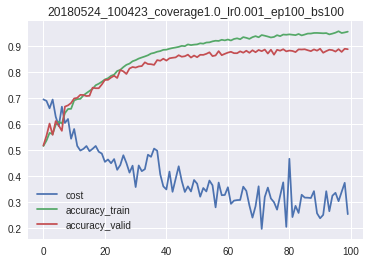

In [16]:
from google.colab import files
from datetime import timezone, timedelta, datetime

dt = datetime.now(timezone.utc)
tz = timezone(timedelta(hours=9))
DatetimeString = dt.astimezone(tz).strftime('%Y%m%d_%H%M%S')
Title = '{}_coverage{:.2}_lr{:.2}_ep{}_bs{}'.format(DatetimeString, TrainDataCoverage, learning_rate, training_epochs, batch_size)
Filename = 'graph_{}.png'.format(Title)

plt.plot(cost, label="cost")
plt.plot(accuracy_t, label="accuracy_train")
plt.plot(accuracy_v, label="accuracy_valid")
plt.title(Title)
plt.legend()
plt.savefig(Filename)
plt.show()

# files.download(Filename)
# !rm $Filename
# !ls -l

In [0]:
train = []
valid = []
train_labels = []
valid_labels = []

##**Prediction**

In [18]:
#@title Test image property { form-width: "20%" }
TestImageCoverage = 1.0 #@param {type:"number"}


import re

print("[Get test image filename list]")
sleep(1)

test_images =  [TEST_DIR+i for i in tqdm(os.listdir(TEST_DIR))]

test_images.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])


# data reduction for test result check efficiency
noTestImage = int(len(test_images) * TestImageCoverage)

print("")
print("Test image count: ", noTestImage)

test_images =  test_images[:noTestImage]

[Get test image filename list]


100%|██████████| 12500/12500 [00:00<00:00, 1160673.88it/s]



Test image count:  12500


In [19]:
print("[Test Image Loading..]")
sleep(1)

test = prep_data(test_images)
print("")
print("Test shape: {}".format(test.shape))

[Test Image Loading..]


100%|██████████| 12500/12500 [00:23<00:00, 543.05it/s]


Test shape: (12500, 64, 64, 3)


In [20]:
print("Test data count: ", len(test))

print('Prediction Started!')

hypothesis = []
prediction = []

total_batch = int(len(test) / batch_size)

for i in trange(total_batch, desc='Prediction loop'):
    start_idx = i       * batch_size;
    end_idx   = (i + 1) * batch_size;

    batch_xs  = test       [start_idx:end_idx,:,:,:]

    h, p = m1.predict(batch_xs)

    hypothesis.extend(h)
    prediction.extend(p)

print('Prediction Finished!')

Prediction loop:   2%|▏         | 3/125 [00:00<00:04, 29.15it/s]

Test data count:  12500
Prediction Started!


Prediction loop: 100%|██████████| 125/125 [00:01<00:00, 65.00it/s]

Prediction Finished!


In [0]:
from google.colab import files

hp = np.array(hypothesis)

submission = pd.DataFrame({
        "id": range(1, len(test_images) + 1), 
        "label": hp[:, 1]
})

submission.to_csv('submission.csv', index=False)

submission = pd.read_csv('submission.csv')
submission.head()

files.download('submission.csv')

!rm 'submission.csv'
#!ls -l

12500
26
1 - Dog: [28.36%, 71.64%]
2 - Dog: [0.00%, 100.00%]
3 - Dog: [0.05%, 99.95%]
4 - Dog: [0.00%, 100.00%]
5 - Cat: [100.00%, 0.00%]
6 - Dog: [32.57%, 67.43%]
7 - Cat: [100.00%, 0.00%]
8 - Cat: [52.79%, 47.21%]
9 - Cat: [99.88%, 0.12%]
10 - Cat: [100.00%, 0.00%]
11 - Cat: [100.00%, 0.00%]
12 - Dog: [3.25%, 96.75%]
13 - Cat: [91.65%, 8.35%]
14 - Cat: [98.06%, 1.94%]
15 - Cat: [100.00%, 0.00%]
16 - Cat: [95.27%, 4.73%]
17 - Dog: [17.68%, 82.32%]
18 - Dog: [0.03%, 99.97%]
19 - Cat: [93.85%, 6.15%]
20 - Cat: [99.52%, 0.48%]
21 - Dog: [5.34%, 94.66%]
22 - Cat: [97.52%, 2.48%]
23 - Dog: [5.23%, 94.77%]
24 - Dog: [43.61%, 56.39%]
25 - Cat: [93.09%, 6.91%]
26 - Dog: [6.33%, 93.67%]


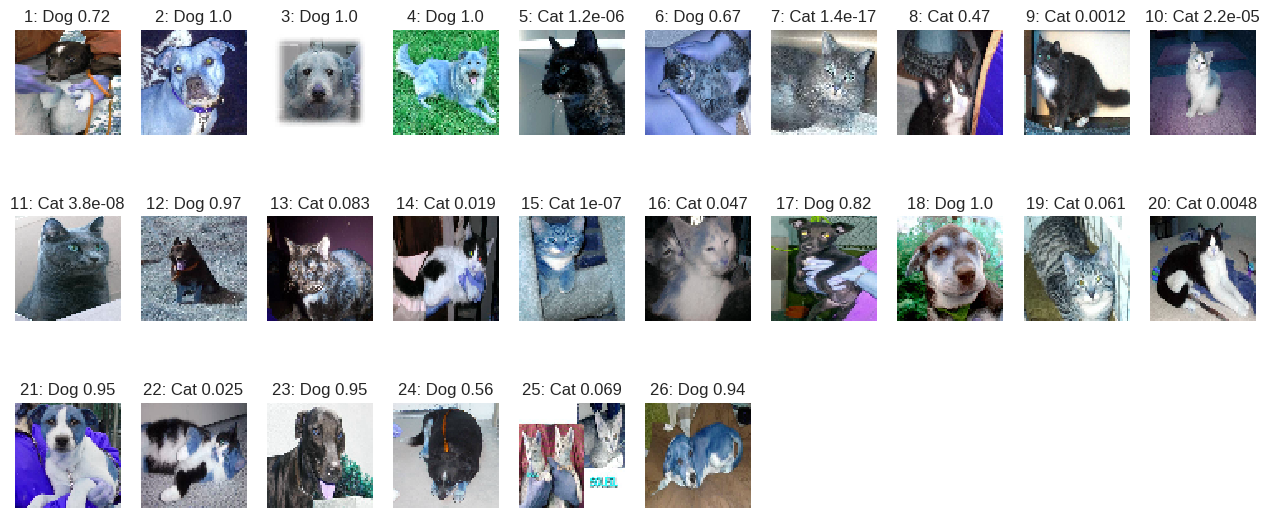

In [22]:
import math

print(len(test_images))
noReviewImage = int(min(len(test_images) * 0.002, 25))
test_images =  test_images[: (noReviewImage + 1)]
print(len(test_images))

plt.figure(figsize=(16,7),dpi=100,facecolor='white')

noSubPlotCol = 10
noSubPlotRow = math.ceil(len(test_images) / noSubPlotCol)

for i in range(len(test_images)):
    sort = ""
    
    if hp[int(i), 0] >= 0.5:
      sort = "Cat"
    else: 
      sort = "Dog"
      
    print('{} - {}: [{:.2%}, {:.2%}]'.format(i + 1, sort, hypothesis[i][0], hypothesis[i][1]))
        
    plt.subplot(noSubPlotRow,noSubPlotCol,i + 1)
    plt.imshow(test[i])
    plt.title('{}: {} {:.2}'.format(i + 1, sort, hypothesis[i][1]))
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])    


plt.show()